In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import pickle
sns.set()

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [15]:
class LifelongForest:
    """
    Lifelong Forest class.
    """
    def __init__(self, acorn=None):
        """
        Two major things the Forest Class needs access to:
            1) the realized random forest model (self.models_ is a list of forests, 1 for each task)
            2) old data (to update posteriors when a new task is introduced)
        """
        self.models_ = []
        self.X_ = []
        self.y_ = []
        self.n_tasks = 0
        self.n_classes = None
        if acorn is not None:
            np.random.seed(acorn)
    def new_forest(self, X, y, n_estimators, max_samples=0.32,
                        bootstrap=True, max_depth=30, min_samples_leaf=1,
                        acorn=None):
        """
        Input
        X: an array-like object of features; X.shape == (n_samples, n_features)
        y: an array-like object of class labels; len(y) == n_samples
        n_estimators: int; number of trees to construct (default = 200)
        max_samples: float in (0, 1]: number of samples to consider when 
            constructing a new tree (default = 0.32)
        bootstrap: bool; If True then the samples are sampled with replacement
        max_depth: int; maximum depth of a tree
        min_samples_leaf: int; minimum number of samples in a leaf node
        Return
        model: a BaggingClassifier fit to X, y
        """
        if X.ndim == 1:
            raise ValueError('1d data will cause headaches down the road')
        if acorn is not None:
            np.random.seed(acorn)
        self.X_.append(X)
        self.y_.append(y)
        n = X.shape[0]
        K = len(np.unique(y))
        if self.n_classes is None:
            self.n_classes = K
        max_features = int(np.ceil(np.sqrt(X.shape[1])))
        
        
        model=BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                                         max_features = max_features),
                                  n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  bootstrap=bootstrap)
        model.fit(X, y)
        
        
        self.models_.append(model)
        self.n_tasks += 1
        self.n_classes = len(np.unique(y))
        return model
    def _get_leaves(self, estimator):
        """
        Internal function to get leaf node ids of estimator.
        Input
        estimator: a fit DecisionTreeClassifier
        Return
        leaf_ids: numpy array; an array of leaf node ids
        Usage
        _estimate_posteriors(..)
        """
        # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left
        children_right = estimator.tree_.children_right
        feature = estimator.tree_.feature
        threshold = estimator.tree_.threshold
        leaf_ids = []
        stack = [(0, -1)] 
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()
            # If we have a test node
            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                leaf_ids.append(node_id)
        return np.array(leaf_ids)
    def _finite_sample_correction(self, class_probs, row_sums):
        """
        An internal function for finite sample correction of posterior estimation.
        Input
        class_probs: numpy array; array of posteriors to correct
        row_sums: numpy array; array of partition counts
        Output
        class_probs: numpy array; finite sample corrected posteriors
        Usage
        _estimate_posteriors(..)
        """
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
        return class_probs
    def _estimate_posteriors(self, test, representation=0, decider=0, subsample=1, acorn=None):
        """
        An internal function to estimate the posteriors.
        Input
        task_number: int; indicates which model in self.model_ to use
        test: array-like; test observation
        in_task: bool; True if test is an in-task observation(s)
        subsample: float in (0, 1]; proportion of out-of-task samples to use to
            estimate posteriors
        Return
        probs: numpy array; probs[i, k] is the probability of observation i
            being class k
        Usage
        predict(..)
        """
        
        if acorn is not None:
            acorn = np.random.seed(acorn)
        if representation==decider:
            in_task=True
        else:
            in_task=False
        train = self.X_[decider]
        y = self.y_[decider]
        model = self.models_[representation]
        n, d = train.shape
        if test.ndim > 1:
            m, d_ = test.shape
        else:
            m = len(test)
            d_ = 1
        size = len(np.unique(y))
        class_counts = np.zeros((m, size))
        
        
        for tree in model:
            # get out of bag indicies
            if in_task:
                prob_indices = _generate_unsampled_indices(tree.random_state, n)
                # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
            else:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)
            leaf_nodes = self._get_leaves(tree)
            unique_leaf_nodes = np.unique(leaf_nodes)
            # get all node counts
            node_counts = tree.tree_.n_node_samples
            # get probs for eval samples
            posterior_class_counts = np.zeros((len(unique_leaf_nodes), size))
            for prob_index in prob_indices:
                temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
                #print(y[prob_index], size, np.unique(y))
                posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1
            # total number of points in a node
            row_sums = posterior_class_counts.sum(axis=1)
            # no divide by zero
            row_sums[row_sums == 0] = 1
            # posteriors
            class_probs = (posterior_class_counts / row_sums[:, None])
            # posteriors with finite sampling correction
            class_probs = self._finite_sample_correction(class_probs, row_sums)
            # posteriors as a list
            class_probs.tolist()
            partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
            # get probability for out of bag samples
            eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
            eval_class_probs = np.array(eval_class_probs)
            # find total elements for out of bag samples
            elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
            # store counts for each x (repeat fhis for each tree)
            class_counts += elems
        # calculate p(y|X = x) for all x's
        probs = class_counts / class_counts.sum(axis=1, keepdims=True)
        
        return probs
    def predict(self, test, representation=0, decider='all', subsample=1, acorn=None):
        """
        Predicts the class labels for each sample in test.
        Input
        test: array-like; either a 1d array of length n_features
            or a 2d array of shape (m, n_features) 
        task_number: int; task number 
        """
        size=len(np.unique(self.y_[decider]))
        sum_posteriors = np.zeros((test.shape[0], size))
        if representation is 'all':
            for i in range(self.n_tasks):
                sum_posteriors += self._estimate_posteriors(test,
                                                            i,
                                                            decider,
                                                            subsample,
                                                            acorn)
        else:
            sum_posteriors += self._estimate_posteriors(test,
                                                        representation,
                                                        decider,
                                                        subsample,
                                                        acorn)
        return np.argmax(sum_posteriors, axis=1)





In [16]:
def get_colors(colors, inds):
    c = [colors[i] for i in inds]
    return c

def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R


def generate_gaussian_parity(n, mean=np.array([-1, -1]), cov_scale=1, angle_params=None, k=1, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    d = len(mean)
    
    if mean[0] == -1 and mean[1] == -1:
        mean = mean + 1 / 2**k
    
    mnt = np.random.multinomial(n, 1/(4**k) * np.ones(4**k))
    cumsum = np.cumsum(mnt)
    cumsum = np.concatenate(([0], cumsum))
    
    Y = np.zeros(n)
    X = np.zeros((n, d))
    
    for i in range(2**k):
        for j in range(2**k):
            temp = np.random.multivariate_normal(mean, cov_scale * np.eye(d), 
                                                 size=mnt[i*(2**k) + j])
            temp[:, 0] += i*(1/2**(k-1))
            temp[:, 1] += j*(1/2**(k-1))
            
            X[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = temp
            
            if i % 2 == j % 2:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 0
            else:
                Y[cumsum[i*(2**k) + j]:cumsum[i*(2**k) + j + 1]] = 1
                
    if d == 2:
        if angle_params is None:
            angle_params = np.random.uniform(0, 2*np.pi)
            
        R = generate_2d_rotation(angle_params)
        X = X @ R
        
    else:
        raise ValueError('d=%i not implemented!'%(d))
       
    return X, Y.astype(int)

In [40]:
def exp(n_sample, n_test, angle_params, n_trees, reps, acorn=None):
    
    if acorn != None:
        np.random.seed(acorn)
        
    error = np.zeros(reps,dtype=float)
    
    for i in range(reps):
        train, label = generate_gaussian_parity(n_sample,cov_scale=0.1,angle_params=angle_params)
        test, test_label = generate_gaussian_parity(n_test,cov_scale=0.1,angle_params=angle_params)
    
        l2f = LifelongForest()
        l2f.new_forest(train, label, n_estimators=n_trees)
    
        uf_task = l2f.predict(test, representation=0, decider=0)
        error[i] = 1 - np.sum(uf_task == test_label)/n_test
    
    return np.mean(error,axis=0), np.std(error,ddof=1,axis=0)

In [41]:
n_trees = np.arange(10,1510,10)
n_test = 1000
n_sample = 1500
reps = 100

error1 = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                delayed(exp)(n_sample,n_test,angle_params=0,n_trees=n_tree,reps=reps) for n_tree in n_trees
                )
            )

error2 = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                delayed(exp)(n_sample,n_test,angle_params=np.pi/4,n_trees=n_tree,reps=reps) for n_tree in n_trees
                )
            )
    
with open('../result/control_xor.pickle','wb') as f:
    pickle.dump(error1,f)
    
with open('../result/control_nxor.pickle','wb') as f:
    pickle.dump(error2,f)
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 341.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 337.7min finished


In [51]:
n_trees = np.arange(10,1510,10)

tmp1 = unpickle('../result/control_xor.pickle')
tmp2 = unpickle('../result/control_nxor.pickle')

err1 = np.zeros(len(n_trees),dtype=float)
err2 = np.zeros(len(n_trees),dtype=float)

for i in range(len(n_trees)):
    err1[i] = 1-tmp1[i][0]
    err2[i] = 1-tmp2[i][0]

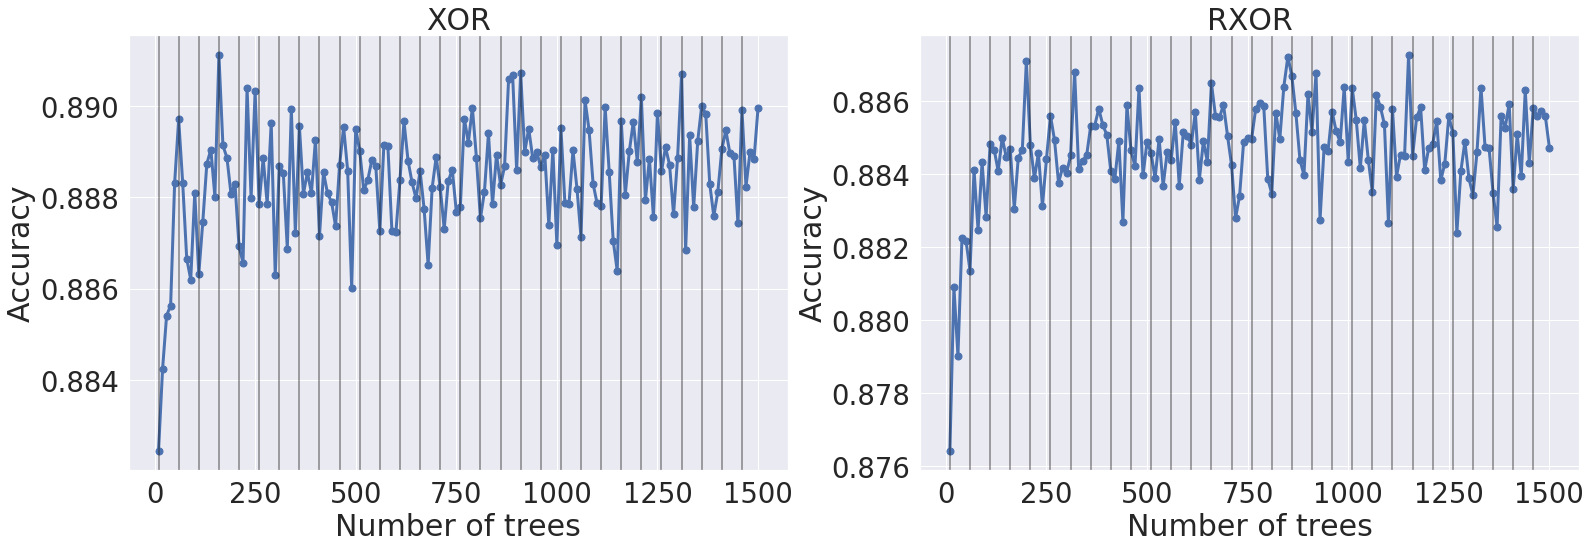

In [76]:
sns.set()

fig, ax = plt.subplots(1,2, figsize=(26,8))
ax[0].plot(n_trees, err1, marker='.', markersize=14, linewidth=3)
ax[1].plot(n_trees, err2, marker='.', markersize=14, linewidth=3)

ax[0].set_title('XOR',fontsize=30)
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Accuracy', fontsize=30)
ax[0].set_xlabel('Number of trees', fontsize=30)
ax[0].tick_params(labelsize=27.5)
#ax.set_xticks(rotation=90)

ax[1].set_title('RXOR',fontsize=30)
ax[1].set_xlabel('Accuracy')
ax[1].set_ylabel('Accuracy', fontsize=30)
ax[1].set_xlabel('Number of trees', fontsize=30)
ax[1].tick_params(labelsize=27.5)

for i in range(10,1510,50):
    ax[0].axvline(x = i, linewidth=1.5,alpha=0.5, color='k')
    ax[1].axvline(x = i, linewidth=1.5,alpha=0.5, color='k')
    
plt.savefig('/data/Jayanta/control_xor_rxor.png',dpi=500)

In [50]:
err2[0][0]

0.87642